In [3]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [545]:
def tmp_solve(sbm, p_reciprocity=0., eta=0., z=0., epsilon=1, precision=10, maxiters=1000000, use_jacobian=True, plot=True, blockwise=False, transpose=False, circles=False, converged=True):
    import numpy as np
    from itertools import product
    from scipy.optimize import fsolve
    
    m = len(sbm['pi'])
    sig = (sbm['psi'] + p_reciprocity*sbm['psi'].T)/2
    rho = p_reciprocity*(sbm['psi'] + sbm['psi'].T)/2
    pi = sbm['pi']
    zzbar = np.real(z*np.conj(z))
    zzbar2 = np.real(z**2 + np.conj(z)**2)
    if transpose:
        p = eta**2 + zzbar + sig@pi
        Q = zzbar2*rho + zzbar*(sig + sig.T) + sig@np.diag(pi)@sig.T
    else:
        p = eta**2 + zzbar + sig.T@pi
        Q = zzbar2*rho + zzbar*(sig + sig.T) + sig.T@np.diag(pi)@sig
    inits = [tuple([0]*2*m)] + list(product(*[epsilon*np.array(list(product([1,-1], [1,-1]))) for i in range(m)]))
    print('p:', p, 'Q:', Q)
    print(inits)
    def xy2z(x, y): return np.hstack([x, y])
    def z2xy(z): return z[:len(z)//2], z[len(z)//2:]
    def foo(z):
        x, y = z2xy(z)
        return xy2z(x*(p-Q@x) + y*(Q@y) - pi, y*(p-Q@x) - x*(Q@y))
    def foo_prime(z):
        x, y = z2xy(z)
        drf_dx = np.diag(p - x*np.diag(Q)) - np.diag(x)@Q
        drf_dy = np.diag(y*np.diag(Q)) + np.diag(y)@Q
        dif_dx = - np.diag(Q@y) - np.diag(y)@Q
        dif_dy = np.diag(p - Q@x) - np.diag(x)@Q
        return np.vstack([np.hstack([drf_dx, drf_dy]), np.hstack([dif_dx, dif_dy])])
    solns = []
    for init in inits:
        if use_jacobian: soln = fsolve(foo, init, fprime=foo_prime, maxfev=maxiters)
        else: soln = fsolve(foo, init, maxfev=maxiters)
        solns.append((init, soln, round(abs(foo(soln)).mean(), precision)))
    if plot:
        import matplotlib.pyplot as plt
        xs = [[] for i in range(m)]
        ys = [[] for i in range(m)]
        cs = [[] for i in range(m)]
        xall = []
        yall = []
        call = []
        color_dict = {True: 'b', False: 'r'}
        for soln in solns:
            x, y = z2xy(soln[1])
            if converged and soln[2]==0: continue
            flag = color_dict[soln[2]!=0]
            xall.append(x)
            yall.append(y)
            call.append(flag)
            for i in range(m):
                xs[i].append(x[i])
                ys[i].append(y[i])
                cs[i].append(flag)
        plt.figure(dpi=120)
        for i in range(len(xall)):
            plt.scatter(xall[i], yall[i], c=call[i])
            plt.plot(xall[i], yall[i], ls=':', c='gray')
            if circles:
                rs = np.sqrt(np.array(xall[i])**2 + np.array(yall[i])**2)
                for r in rs: plt.gca().add_artist(plt.Circle((0, 0), r, color='gray', fill=False))
        plt.gca().axhline(0, ls='--', c='black')
        plt.gca().axvline(0, ls='--', c='black')
        plt.gca().set_aspect('equal')
        plt.xlabel('re')
        plt.ylabel('im')
        plt.title('solutions for all %i blocks'%m)
        plt.show()
        plt.figure(dpi=120)
        for i in range(len(xall)):
            if call[i]=='b': plt.scatter(sum(xall[i]), sum(yall[i]), c=call[i], marker='+')
            else: plt.scatter(sum(xall[i]), sum(yall[i]), c=call[i], marker='x')
        plt.gca().axhline(0, ls='--', c='black')
        plt.gca().axvline(0, ls='--', c='black')
        plt.gca().set_aspect('equal')
        plt.xlabel('re')
        plt.ylabel('im')
        plt.title('sum of solutions over all %i blocks'%m)
        plt.show()
        if blockwise:
            for i in range(m):
                plt.scatter(xs[i], ys[i], c=cs[i], marker='o')
                plt.gca().axhline(0, ls='--', c='black')
                plt.gca().axvline(0, ls='--', c='black')
                plt.gca().set_aspect('equal')
                plt.xlabel('re')
                plt.ylabel('im')
                plt.title('solutions for block %i'%(i+1))
                plt.show()
        idx = np.round(np.array(yall).sum(1), precision)==0
        return np.array(xall)[idx,:], np.array(yall)[idx,:]

In [540]:
m = 1
w = 1
psi = np.vstack([1*np.ones((m//2,m)), 2*w*np.ones((m-m//2,m))])
#np.fill_diagonal(psi, 0)
sbm = {'pi': np.ones(m)/m, 'psi':psi , 'undirected': True}
print(sbm)

{'pi': array([1.]), 'psi': array([[2.]]), 'undirected': True}


p: [1.] Q: [[1.]]
[(0, 0), (array([1, 1]),), (array([ 1, -1]),), (array([-1,  1]),), (array([-1, -1]),)]


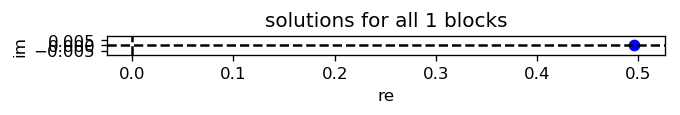

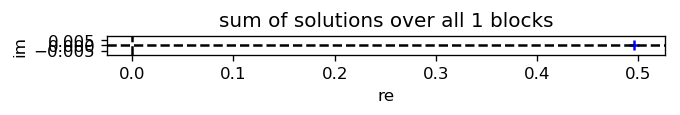

In [546]:
sol = tmp_solve(sbm, p_reciprocity=0)

In [547]:
sol

(array([[0.49609375]]), array([[-5.8900417e-16]]))

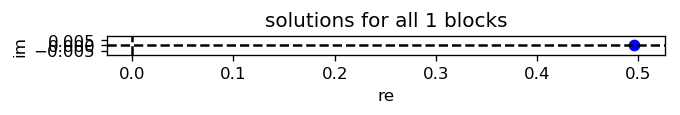

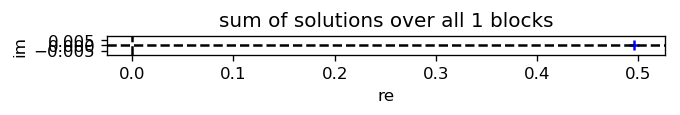

array([[0.49609375]])

In [523]:
tmp_solve(sbm, p_reciprocity=0, transpose=True)

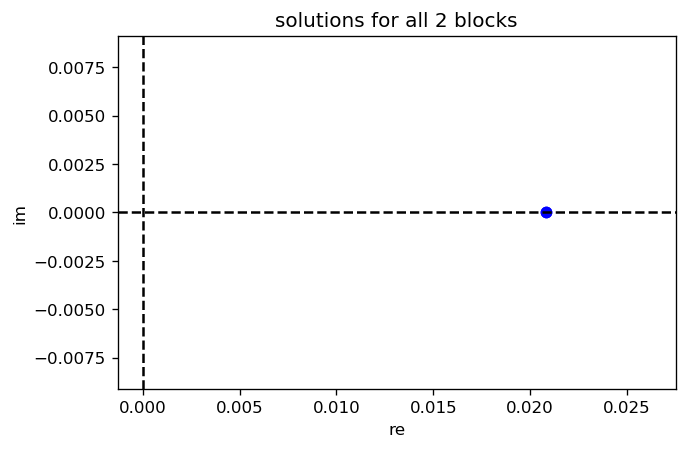

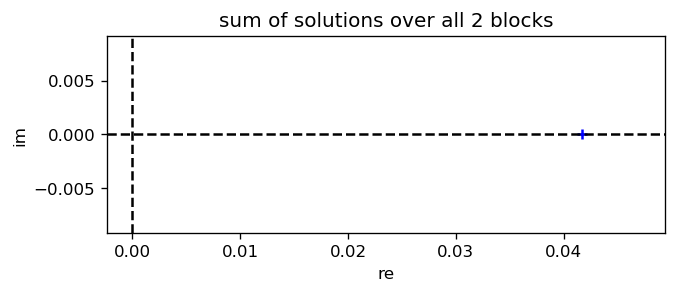

array([[0.02083333, 0.02083333]])

In [518]:
tmp_solve(sbm, p_reciprocity=1)

In [178]:
def rank_k_update(k=3, m=3):
    import sympy as sym
    sym.init_printing()
    one = sym.Identity(m)
    A = [sym.MatrixSymbol('A', m, m)]
    A_inv = [sym.Inverse(A[0])]
    u = [sym.MatrixSymbol('u'+str(i+1), m, m) for i in range(m)]
    v = [sym.MatrixSymbol('v'+str(i+1), m, m) for i in range(m)]
    det = [sym.symbol('d')]
    for i in range(k):
        A.append(A[-1] + sym.MatMul(u[i], sym.Transpose(v[i])))
        A_inv.append((A_inv[-1] - sym.MatMul(sym.Inverse((one + sym.MatMul(sym.Transpose(v[i]), A_inv[-1], u[i]))), A_inv[-1], u[i], sym.Transpose(v[i]), A_inv[-1])).simplify())
        det.append()
    return A_inv

In [179]:
out = rank_k_update()

In [189]:
out[2]

In [229]:
def test(n=1000, num=100, eta=0., z=1, var=1.):
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    x_s = []
    b_s = []
    binv_s = []
    binv_xh_s = []
    for i in range(num):
        x = np.random.randn(n, n)*np.sqrt(var/n)
        b = (z+eta**2/np.sqrt(n))*np.eye(n) + np.dot(x.T, x)
        binv = np.linalg.inv(b)
        binv_xh = np.dot(binv, x.T)
        x_s.append(x)
        b_s.append(b)
        binv_s.append(binv)
        binv_xh_s.append(binv_xh)
    cor_mean = np.dstack([i*i.T for i in b_s]).mean(-1)
    np.fill_diagonal(cor_mean, 0)
    b_mean = np.dstack(b_s).mean(-1)
    binv_mean = np.dstack(binv_s).mean(-1)
    binv_mean_est = 1/(np.diag(b_mean) - np.dot(cor_mean, np.diag(binv_mean)))
    binv_xh_mean = np.dstack(binv_xh_s).mean(-1)
    sns.heatmap(cor_mean, square=True)
    plt.title('$\\langle P\\rangle$')
    plt.show()
    sns.heatmap(b_mean, square=True)
    plt.title('$\\langle B\\rangle$')
    plt.show()
    sns.heatmap(binv_mean, square=True, center=0, cmap='Spectral')
    plt.title('$\\langle B^{-1}\\rangle$')
    plt.show()
    sns.heatmap(binv_xh_mean, square=True, center=0, cmap='Spectral')
    plt.title('$\\langle B^{-1}X^H\\rangle$')
    plt.show()
    sns.distplot(np.diag(binv_mean))
    plt.title('$\\langle B^{-1}\\rangle$')
    plt.show()
    sns.distplot(binv_mean_est)
    plt.title('$\\widebar{\\langle B^{-1}\\rangle}$')
    plt.show()
    sns.distplot(np.diag(binv_mean)-binv_mean_est)
    plt.title('$\\langle B^{-1}\\rangle-\\widebar{\\langle B^{-1}\\rangle}$')
    plt.show()

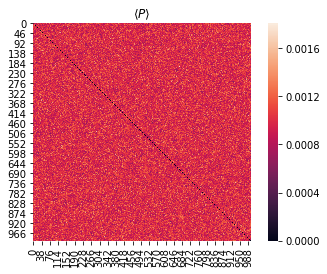

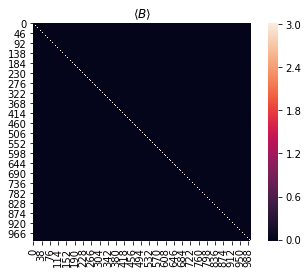

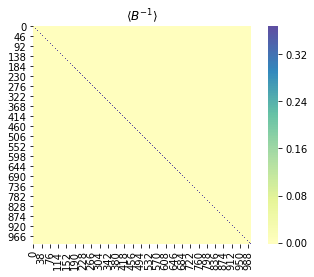

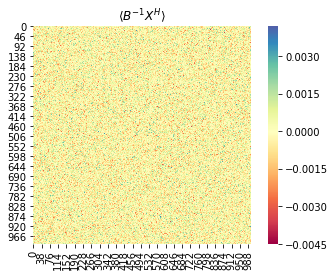

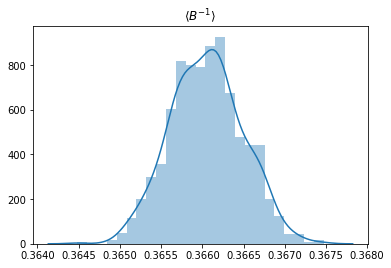

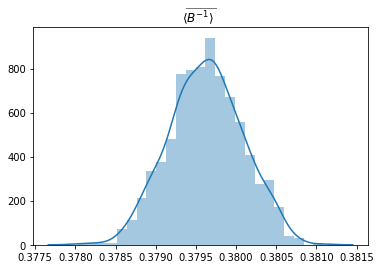

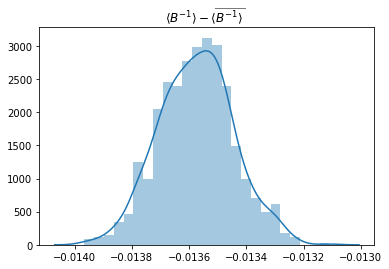

In [238]:
test(z=2)

In [34]:
def solve_f(sbm, p_reciprocate=0., nbins=200, eta=1e-2, factor=1e-1, tol=1e-10, cutoff=None, surface=False):
    import numpy as np
    from scipy.optimize import fsolve
    
    psi = (sbm['psi']+p_reciprocate*sbm['psi'].T)/2
    pi = sbm['pi']
    rho = p_reciprocate*(sbm['psi']+sbm['psi'].T)/2
    m = len(psi)
    
    def r2c(x):
        l = len(x)//2
        return x[:l] + 1j*x[l:]
        
    def c2r(x):
        return np.hstack([np.real(x), np.imag(x)])
    
    def init(z, transpose=False):
        z = r2c(z)
        if transpose:
            a = (np.dot(psi, pi[:,np.newaxis]*psi.T) + z*np.conj(z)*(psi + psi.T) + (z**2+np.conj(z)**2)*rho).sum()
            b =  m*(z*np.conj(z)+eta**2) + np.dot(psi, pi).sum()
        else:
            a = (np.dot(psi.T, pi[:,np.newaxis]*psi) + z*np.conj(z)*(psi + psi.T) + (z**2+np.conj(z)**2)*rho).sum()
            b =  m*(z*np.conj(z)+eta**2) + np.dot(psi.T, pi).sum()
        d = b**2-4*a
        if d<0: sol1, sol2 = (b + 1j*np.sqrt(-d))/(2*a), (b - 1j*np.sqrt(-d))/(2*a)
        else: sol1, sol2 = (b + np.sqrt(d))/(2*a), (b - np.sqrt(d))/(2*a)
        return c2r(np.repeat(sol1, m)), c2r(np.repeat(sol2, m)), np.real(d)
    
    def foo(f, z):
        f = r2c(f)
        z = r2c(z)
        return c2r(f*((z*np.conj(z)) + eta**2 + np.dot(psi.T, pi) - np.dot(z*np.conj(z)*(psi + psi.T) + (z**2+np.conj(z)**2)*rho + np.dot(psi.T, pi[:,np.newaxis]*psi), f)) - pi)
        
    def foo2(f, z):
        f = r2c(f)
        z = r2c(z)
        return c2r(f*((z*np.conj(z)) + eta**2 + np.dot(psi, pi) - np.dot(z*np.conj(z)*(psi + psi.T) + (z**2+np.conj(z)**2)*rho + np.dot(psi, pi[:,np.newaxis]*psi.T), f)) - pi)
        
    def foo_prime(f, z):
        f = r2c(f)
        z = r2c(z)
        p = z*np.conj(z) + eta**2 + np.dot(psi.T, pi)
        p_prime = z
        Q = z*np.conj(z)*(psi + psi.T) + (z**2+np.conj(z)**2)*rho + np.dot(psi.T, pi[:,np.newaxis]*psi)
        Q_prime = z*(psi + psi.T) + 2*np.conj(z)*rho
        A = f[:,np.newaxis]*Q - np.diag(p - np.dot(Q, f))
        f_prime = np.dot(np.linalg.inv(A), f*(p_prime - np.dot(Q_prime, f)))
        return f_prime
    
    def g(f, z):
        f = r2c(f)
        z = r2c(z)
        return np.dot(f, np.conj(z)*(1-np.dot(psi, f)) - z*np.dot(rho, f))/np.pi
    
    def g_prime(f, z, f_prime=None):
        if f_prime is None: f_prime = foo_prime(f, z)
        f = r2c(f)
        z = r2c(z)
        return (np.dot(f_prime, - np.dot(z*(rho + rho.T) - np.conj(z)*(psi + psi.T), f)) - np.dot(f, np.dot(psi, f)) + f.sum() + np.conj(z)*f_prime.sum())/np.pi
    
    def g_prime(f, z, f_prime=None):
        f = r2c(f)
        return (f.sum() - np.dot(f, np.dot(psi, f)))/np.pi
    
    mat = (pi[:,np.newaxis]**0.5)*psi*(pi[np.newaxis,:]**0.5)
    if p_reciprocate==1: radius = np.max(np.linalg.eigvalsh(mat))
    else: radius = np.max(np.real(np.linalg.eigvals(mat)))
                  
    lim = (-radius, radius)
    z_orig = [np.linspace(lim[0], lim[1], nbins)]*2
    z_all = np.meshgrid(*z_orig, indexing='ij')
    z_s = np.vstack([z_all[0].flatten(), z_all[1].flatten()]).T
    f1s = []
    f2s = []
    fpr1 = []
    fpr2 = []
    spd1 = []
    spd2 = []
    cor1 = []
    cor2 = []
    disc = []
    for z in z_s:
        init1, init2, d = init(z)
        f1 = fsolve(foo, init1, args=z, xtol=tol)
        f2 = fsolve(foo, init2, args=z, xtol=tol)
        h2 = fsolve(foo2, init1, args=z, xtol=tol)
        h1 = fsolve(foo2, init2, args=z, xtol=tol)
        fp1 = foo_prime(f1, z)
        fp2 = foo_prime(f2, z)
        f1s.append(f1)
        f2s.append(f2)
        fpr1.append(fp1[0])
        fpr2.append(fp2[0])
        spd1.append(g_prime(h2, z, fp1))
        spd2.append(g_prime(h1, z, fp2))
        cor1.append(r2c(f1).sum()*r2c(h1).sum())
        cor2.append(r2c(f2).sum()*r2c(h2).sum())
        disc.append(d)
    fpr1 = np.array(fpr1).reshape((nbins, nbins)).T
    fpr2 = np.array(fpr2).reshape((nbins, nbins)).T
    spd1 = np.array(spd1).reshape((nbins, nbins)).T
    spd2 = np.array(spd2).reshape((nbins, nbins)).T
    cor1 = np.array(cor1).reshape((nbins, nbins)).T
    cor2 = np.array(cor2).reshape((nbins, nbins)).T
    disc = np.array(disc).reshape((nbins, nbins)).T
    
    def plot_contour(x, y, z, title='', xlab='re($\\lambda$)', ylab='im($\\lambda$)', cmap='Spectral'):
        if surface:
            from mpl_toolkits.mplot3d import Axes3D
            fig = plt.figure()
            ax = fig.gca(projection='3d')
            surf = ax.plot_surface(x, y, z, cmap=cmap)
            ax.set_xlabel(xlab)
            ax.set_ylabel(ylab)
            plt.colorbar(surf)
        else:
            plt.contourf(x, y, z, cmap=cmap)
            plt.xlabel(xlab)
            plt.ylabel(ylab)
            plt.colorbar()
            plt.gca().set_aspect('equal')
        plt.title(title)
        plt.show()
        
    def plot_line(x, y, xlab, ylab):
        if not isinstance(y, list):
            y = [y]
            ylab = [ylab]
        for i in range(len(y)):
            p = plt.plot(x, np.real(y[i]), linestyle='-', label='re('+ylab[i]+')')
            plt.plot(x, np.imag(y[i]), color=p[-1].get_color(), linestyle='--', label='im('+ylab[i]+')')
        plt.gca().axhline(0, linestyle=':', color='black')
        plt.xlabel(xlab)
        plt.title(', '.join(ylab)+' vs. '+xlab)
        plt.legend(bbox_to_anchor=(1.1, 1.0), loc='upper left')
        if cutoff is not None: plt.gca().set_ylim((0, cutoff))
        plt.show()
        
    plot_contour(z_all[0], z_all[1], disc, 'discriminant')
    plot_contour(z_all[0], z_all[1], np.real(fpr1), 're($\\langle f_1\\rangle(\\lambda)$)')
    plot_contour(z_all[0], z_all[1], np.real(fpr2), 're($\\langle f_2\\rangle(\\lambda)$)')
    plot_contour(z_all[0], z_all[1], np.imag(fpr1), 'im($\\langle f_1\\rangle(\\lambda)$)')
    plot_contour(z_all[0], z_all[1], np.imag(fpr2), 'im($\\langle f_2\\rangle(\\lambda)$)')
    plot_contour(z_all[0], z_all[1], np.real(spd1), 're($\\rho_1(\\lambda)$)')
    plot_contour(z_all[0], z_all[1], np.real(spd2), 're($\\rho_2(\\lambda)$)')
    plot_contour(z_all[0], z_all[1], np.imag(spd1), 'im($\\rho_1(\\lambda)$)')
    plot_contour(z_all[0], z_all[1], np.imag(spd2), 'im($\\rho_2(\\lambda)$)')
    plot_contour(z_all[0], z_all[1], np.real(spd1+spd2), 're($\\rho_1+\\rho_2(\\lambda)$)')
    plot_contour(z_all[0], z_all[1], np.imag(spd1+spd2), 'im($\\rho_1+\\rho_2(\\lambda)$)')
    plot_contour(z_all[0], z_all[1], np.real(cor1), 're($\\mathcal{C}_1(\\lambda)$)')
    plot_contour(z_all[0], z_all[1], np.real(cor2), 're($\\mathcal{C}_2(\\lambda)$)')
    plot_contour(z_all[0], z_all[1], np.imag(cor1), 'im($\\mathcal{C}_1(\\lambda)$)')
    plot_contour(z_all[0], z_all[1], np.imag(cor2), 'im($\\mathcal{C}_2(\\lambda)$)')
    
    plot_line(z_orig[0], [spd1.sum(1)/(2*radius), spd2.sum(1)/(2*radius), cor1.sum(1)/(2*radius), cor2.sum(1)/(2*radius)], 're$(\\lambda)$', ['$\\rho_1($re$(\\lambda))$', '$\\rho_2($re$(\\lambda))$', '$\\mathcal{C}_1($re$(\\lambda))$', '$\\mathcal{C}_2($re$(\\lambda))$'])
    plot_line(z_orig[1], [spd1.sum(0)/(2*radius), spd2.sum(0)/(2*radius), cor1.sum(0)/(2*radius), cor2.sum(0)/(2*radius)], 'im$(\\lambda)$', ['$\\rho_1($im$(\\lambda))$', '$\\rho_2($im$(\\lambda))$', '$\\mathcal{C}_1($im$(\\lambda))$', '$\\mathcal{C}_2($im$(\\lambda))$'])
    plot_line(z_orig[0], (spd1+spd2).sum(1)/(2*radius), 're$(\\lambda)$', '$\\rho_1+\\rho_2($re$(\\lambda))$')
    plot_line(z_orig[1], (spd1+spd2).sum(0)/(2*radius), 'im$(\\lambda)$', '$\\rho_1+\\rho_2($im$(\\lambda))$')
    return f1s, f2s

In [147]:
def solve_simple(sbm, p_reciprocate=0., nbins=200, eta=1e-2, factor=1e-1, tol=1, cutoff=None, surface=False):
    import numpy as np
    from scipy.optimize import fsolve
    import sympy as sym
    from sympy.plotting import plot3d
    
    psi = (sbm['psi']+p_reciprocate*sbm['psi'].T)/2
    pi = sbm['pi']
    rho = p_reciprocate*(sbm['psi']+sbm['psi'].T)/2
    m = len(psi)
    
    def r2c(x):
        l = len(x)//2
        return x[:l] + 1j*x[l:]
        
    def c2r(x):
        return np.hstack([np.real(x), np.imag(x)])
    
    def analytic(z=None, transpose=False):
        if z is None: z = sym.symbols('z')
        varsum = np.dot(psi.T, pi[:,np.newaxis]*psi).sum()
        sigsum = 2*psi.sum()
        rhosum = rho.sum()
        a = varsum + z*sym.conjugate(z)*sigsum + (z**2+sym.conjugate(z)**2)*rhosum
        c = z*sigsum + 2*sym.conjugate(z)*rhosum
        if transpose: b =  m*(z*sym.conjugate(z)+eta**2) + np.dot(psi, pi).sum()
        else: b =  m*(z*sym.conjugate(z)+eta**2) + np.dot(psi.T, pi).sum()
        d = b**2-4*a
        f1, f2 = sym.simplify((b + sym.sqrt(d))/(2*a)), sym.simplify((b - sym.sqrt(d))/(2*a))
        def df_dzbar(f):
            exp_dnone = sym.simplify(f*(z*m-f*c)/(2*f*a-b))
            exp_dzero = sym.simplify(-f*z*m/b)            
            return sym.Piecewise((exp_dzero, sym.Abs(d)<tol), (exp_dnone, True))
        def g(f): return sym.simplify(f**2*(sym.conjugate(z)*sigsum/2+z*rhosum) + sym.conjugate(z)*f*m)
        def dg_dzbar(f):
            f_ = df_dzbar(f)
            return sym.simplify(m*(f+sym.conjugate(z)*f_) + f*(f*sigsum/2 + f_*(sym.conjugate(z)*sigsum+2*z*rhosum)))
        return f1, f2, dg_dzbar(f1), dg_dzbar(f2)
                                
    mat = (pi[:,np.newaxis]**0.5)*psi*(pi[np.newaxis,:]**0.5)
    if p_reciprocate==1: radius = np.max(np.linalg.eigvalsh(mat))
    else: radius = np.max(np.real(np.linalg.eigvals(mat)))    
    
    x, y = sym.symbols('x y', real=True)
    z = x + sym.I*y
    sol = analytic(z)
    cor1 = sol[0].as_real_imag()
    cor2 = sol[1].as_real_imag()
    sol1 = sol[2].as_real_imag()
    sol2 = sol[3].as_real_imag()
    plot3d(sol1[0])
    plot3d(sol1[1])
    plot3d(cor1[0])
    plot3d(cor1[1])
    plot3d(sol2[0])
    plot3d(sol2[1])
    plot3d(cor2[0])
    plot3d(cor2[1])
    
    '''lim = (-radius, radius)
    z_orig = [np.linspace(lim[0], lim[1], nbins)]*2
    z_all = np.meshgrid(*z_orig, indexing='ij')
    z_s = np.vstack([z_all[0].flatten(), z_all[1].flatten()]).T
    spd1 = []
    spd2 = []
    cor1 = []
    cor2 = []
    disc = []
    for z in z_s:
        init1, init2, d = init(z)
        f1 = init1#fsolve(foo, init1, args=z, xtol=tol)
        f2 = init2#fsolve(foo, init2, args=z, xtol=tol)
        h1 = init1#fsolve(foo2, init1, args=z, xtol=tol)
        h2 = init2#fsolve(foo2, init2, args=z, xtol=tol)
        spd1.append(g_prime(f1, z))
        spd2.append(g_prime(f2, z))
        cor1.append(r2c(f1).sum()*r2c(h1).sum())
        cor2.append(r2c(f2).sum()*r2c(h2).sum())
        disc.append(d)
    spd1 = np.array(spd1).reshape((nbins, nbins)).T
    spd2 = np.array(spd2).reshape((nbins, nbins)).T
    cor1 = np.array(cor1).reshape((nbins, nbins)).T
    cor2 = np.array(cor2).reshape((nbins, nbins)).T
    disc = np.array(disc).reshape((nbins, nbins)).T
    
    def plot_contour(x, y, z, title='', xlab='re($\\lambda$)', ylab='im($\\lambda$)', cmap='Spectral'):
        if surface:
            from mpl_toolkits.mplot3d import Axes3D
            fig = plt.figure()
            ax = fig.gca(projection='3d')
            surf = ax.plot_surface(x, y, z, cmap=cmap)
            ax.set_xlabel(xlab)
            ax.set_ylabel(ylab)
            plt.colorbar(surf)
        else:
            plt.contourf(x, y, z, cmap=cmap)
            plt.xlabel(xlab)
            plt.ylabel(ylab)
            plt.colorbar()
            plt.gca().set_aspect('equal')
        plt.title(title)
        plt.show()
        
    def plot_line(x, y, xlab, ylab):
        if not isinstance(y, list):
            y = [y]
            ylab = [ylab]
        for i in range(len(y)):
            p = plt.plot(x, np.real(y[i]), linestyle='-', label='re('+ylab[i]+')')
            plt.plot(x, np.imag(y[i]), color=p[-1].get_color(), linestyle='--', label='im('+ylab[i]+')')
        plt.gca().axhline(0, linestyle=':', color='black')
        plt.xlabel(xlab)
        plt.title(', '.join(ylab)+' vs. '+xlab)
        plt.legend(bbox_to_anchor=(1.1, 1.0), loc='upper left')
        if cutoff is not None: plt.gca().set_ylim((0, cutoff))
        plt.show()
        
    plot_contour(z_all[0], z_all[1], disc, 'discriminant')
    plot_contour(z_all[0], z_all[1], np.real(spd1), 're($\\rho_1(\\lambda)$)')
    plot_contour(z_all[0], z_all[1], np.real(spd2), 're($\\rho_2(\\lambda)$)')
    plot_contour(z_all[0], z_all[1], np.imag(spd1), 'im($\\rho_1(\\lambda)$)')
    plot_contour(z_all[0], z_all[1], np.imag(spd2), 'im($\\rho_2(\\lambda)$)')
    plot_contour(z_all[0], z_all[1], np.real(cor1), 're($\\mathcal{C}_1(\\lambda)$)')
    plot_contour(z_all[0], z_all[1], np.real(cor2), 're($\\mathcal{C}_2(\\lambda)$)')
    plot_contour(z_all[0], z_all[1], np.imag(cor1), 'im($\\mathcal{C}_1(\\lambda)$)')
    plot_contour(z_all[0], z_all[1], np.imag(cor2), 'im($\\mathcal{C}_2(\\lambda)$)')
    
    plot_line(z_orig[0], [spd1.sum(1)/(2*radius), spd2.sum(1)/(2*radius), cor1.sum(1)/(2*radius), cor2.sum(1)/(2*radius)], 're$(\\lambda)$', ['$\\rho_1($re$(\\lambda))$', '$\\rho_2($re$(\\lambda))$', '$\\mathcal{C}_1($re$(\\lambda))$', '$\\mathcal{C}_2($re$(\\lambda))$'])
    plot_line(z_orig[1], [spd1.sum(0)/(2*radius), spd2.sum(0)/(2*radius), cor1.sum(0)/(2*radius), cor2.sum(0)/(2*radius)], 'im$(\\lambda)$', ['$\\rho_1($im$(\\lambda))$', '$\\rho_2($im$(\\lambda))$', '$\\mathcal{C}_1($im$(\\lambda))$', '$\\mathcal{C}_2($im$(\\lambda))$'])'''

C:\ProgramData\Anaconda3\lib\site-packages\sympy\plotting\experimental_lambdify.py:165: UserWarning: The evaluation of the expression is problematic. We are trying a failback method that may still work. Please report this as a bug.
  warnings.warn('The evaluation of the expression is'


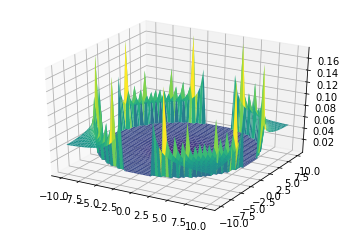

KeyboardInterrupt: 

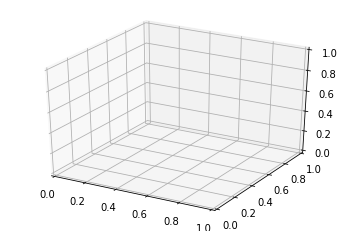

In [148]:
sol = solve_simple(sbm)

C:\ProgramData\Anaconda3\lib\site-packages\sympy\plotting\experimental_lambdify.py:165: UserWarning: The evaluation of the expression is problematic. We are trying a failback method that may still work. Please report this as a bug.
  warnings.warn('The evaluation of the expression is'


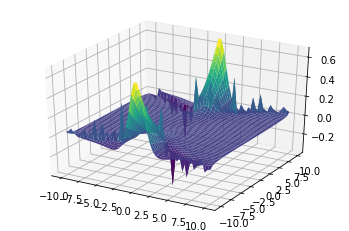

C:\ProgramData\Anaconda3\lib\site-packages\sympy\plotting\experimental_lambdify.py:165: UserWarning: The evaluation of the expression is problematic. We are trying a failback method that may still work. Please report this as a bug.
  warnings.warn('The evaluation of the expression is'


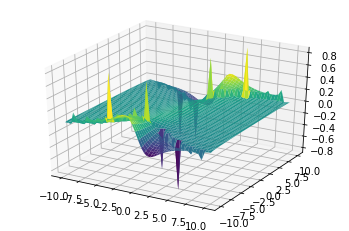

C:\ProgramData\Anaconda3\lib\site-packages\sympy\plotting\experimental_lambdify.py:165: UserWarning: The evaluation of the expression is problematic. We are trying a failback method that may still work. Please report this as a bug.
  warnings.warn('The evaluation of the expression is'


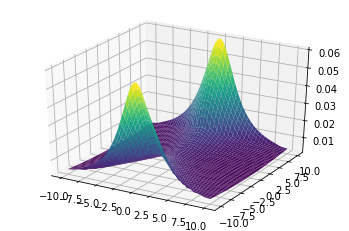

C:\ProgramData\Anaconda3\lib\site-packages\sympy\plotting\experimental_lambdify.py:165: UserWarning: The evaluation of the expression is problematic. We are trying a failback method that may still work. Please report this as a bug.
  warnings.warn('The evaluation of the expression is'


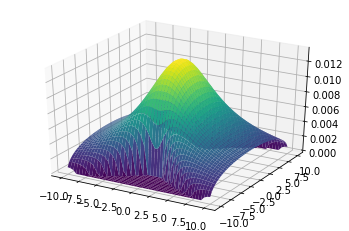

C:\ProgramData\Anaconda3\lib\site-packages\sympy\plotting\experimental_lambdify.py:165: UserWarning: The evaluation of the expression is problematic. We are trying a failback method that may still work. Please report this as a bug.
  warnings.warn('The evaluation of the expression is'


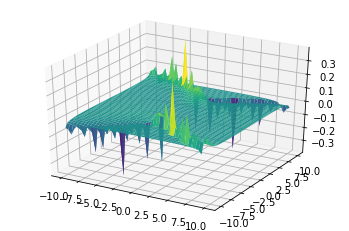

C:\ProgramData\Anaconda3\lib\site-packages\sympy\plotting\experimental_lambdify.py:165: UserWarning: The evaluation of the expression is problematic. We are trying a failback method that may still work. Please report this as a bug.
  warnings.warn('The evaluation of the expression is'


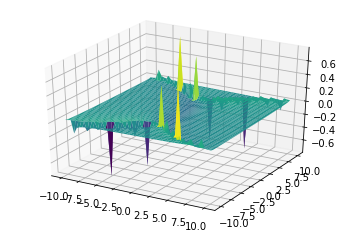

C:\ProgramData\Anaconda3\lib\site-packages\sympy\plotting\experimental_lambdify.py:165: UserWarning: The evaluation of the expression is problematic. We are trying a failback method that may still work. Please report this as a bug.
  warnings.warn('The evaluation of the expression is'


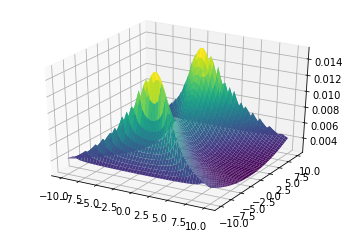

C:\ProgramData\Anaconda3\lib\site-packages\sympy\plotting\experimental_lambdify.py:165: UserWarning: The evaluation of the expression is problematic. We are trying a failback method that may still work. Please report this as a bug.
  warnings.warn('The evaluation of the expression is'


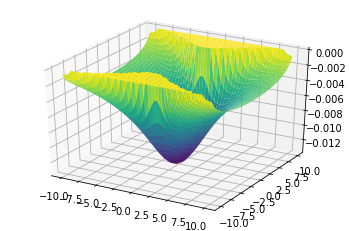

In [132]:
sol = solve_simple(sbm, p_reciprocate=1)

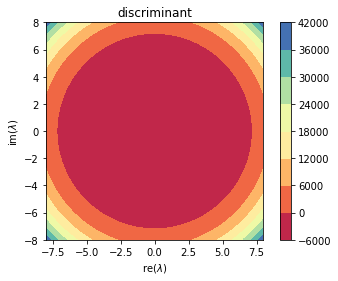

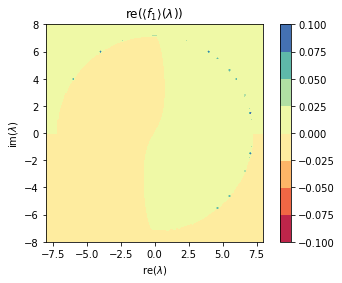

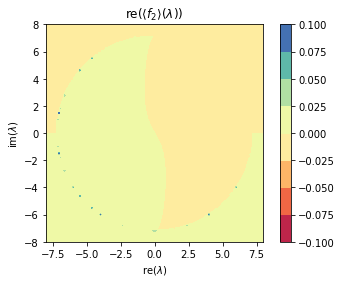

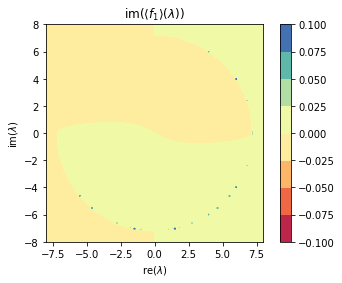

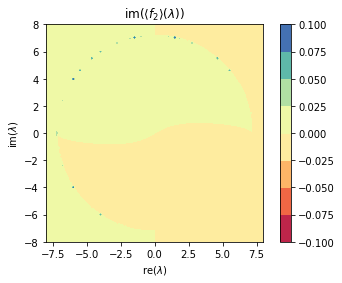

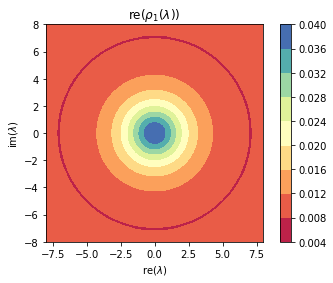

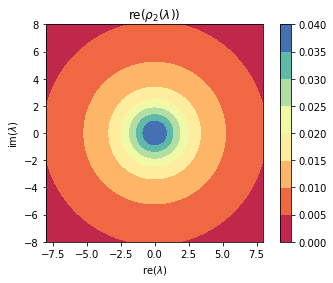

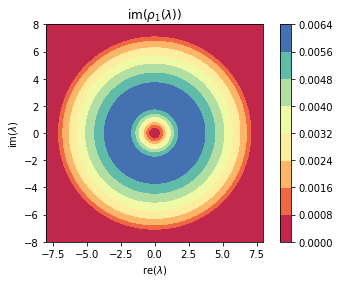

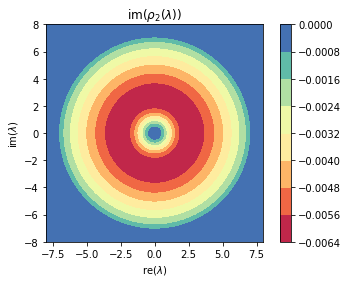

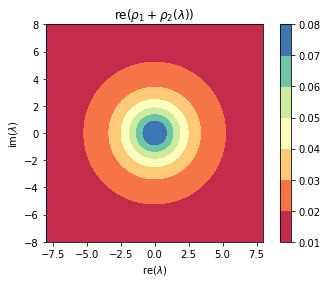

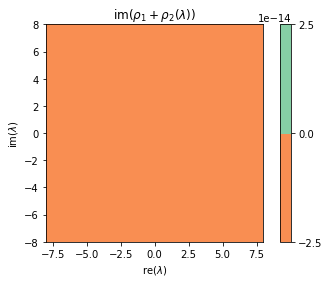

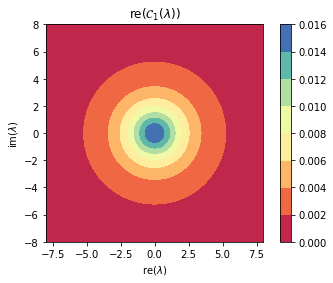

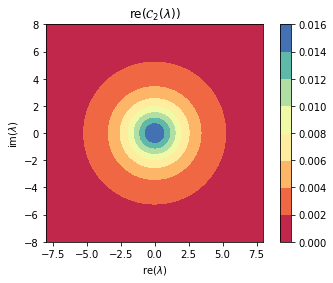

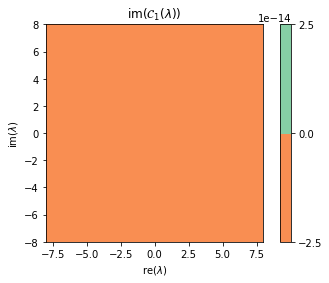

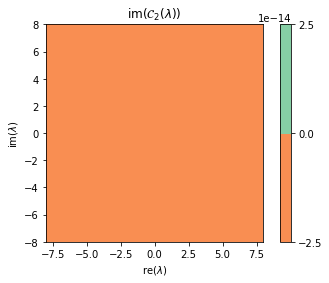

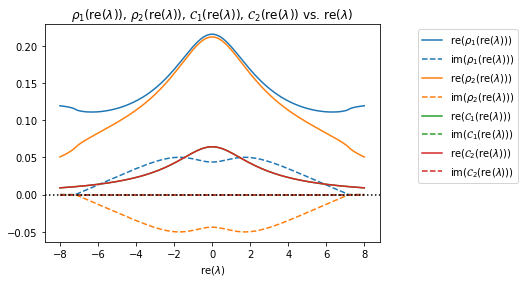

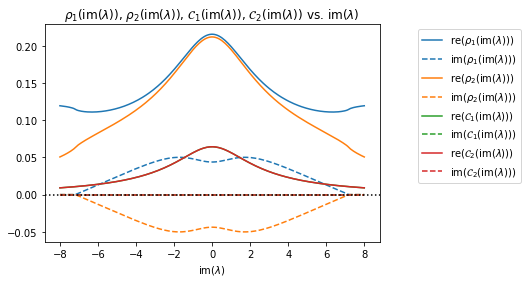

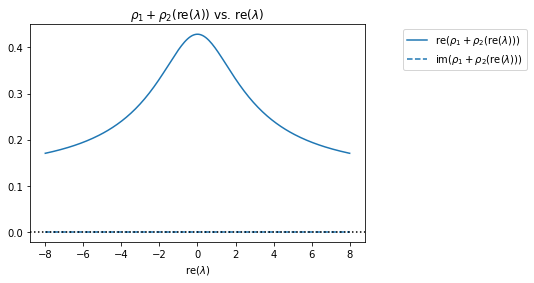

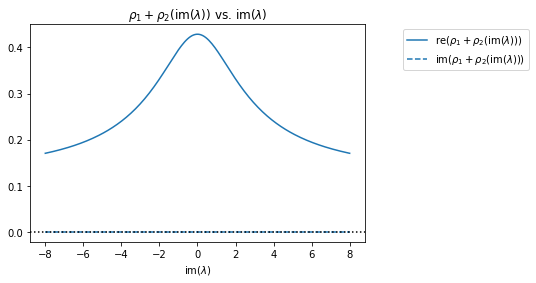

In [35]:
sbm = {'pi': np.array([0.5, 0.5]), 'psi': np.array([[ 16., 16.], [16.,  16.]]), 'undirected': True}
fs = solve_f(sbm)

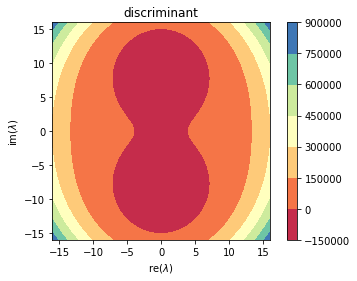

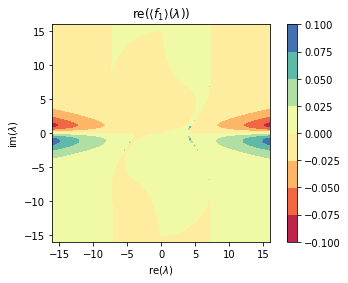

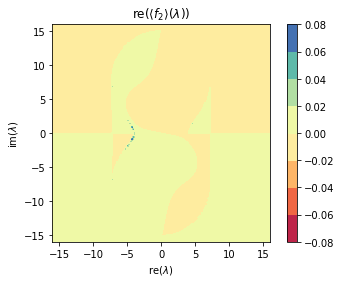

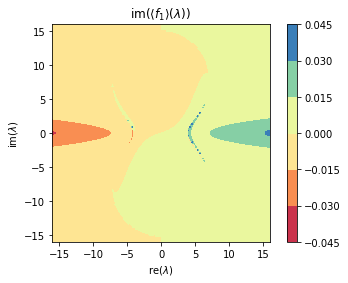

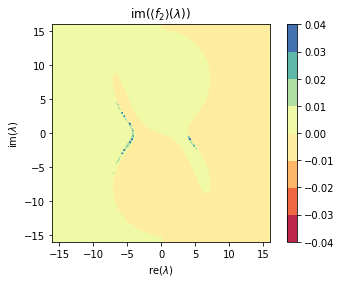

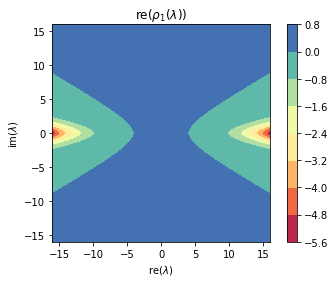

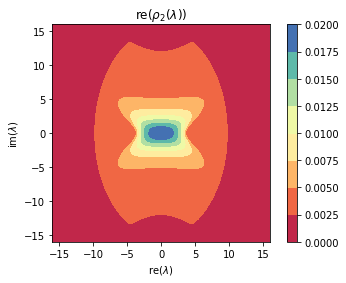

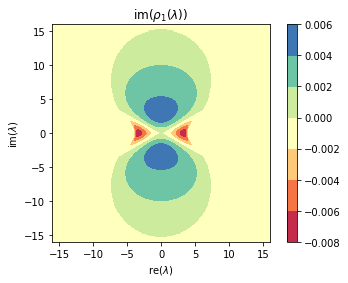

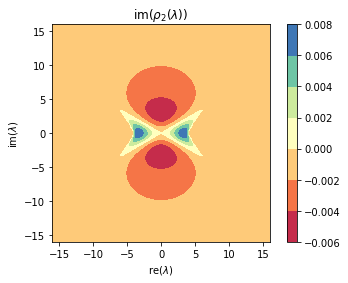

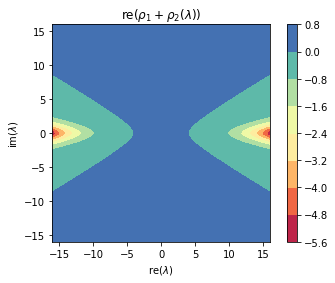

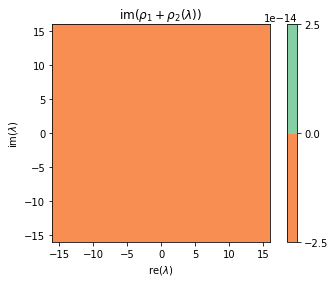

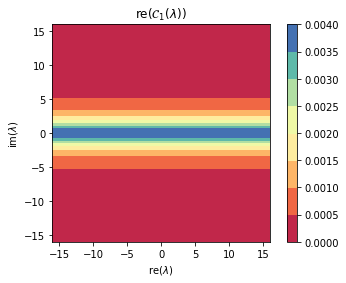

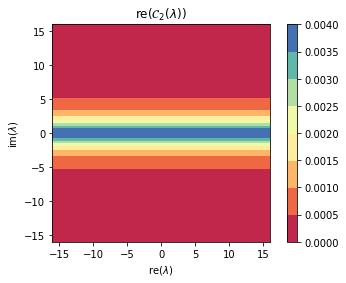

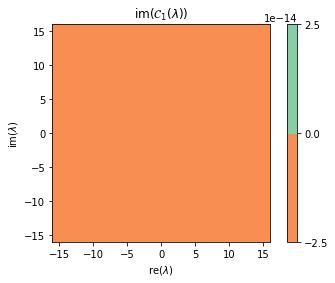

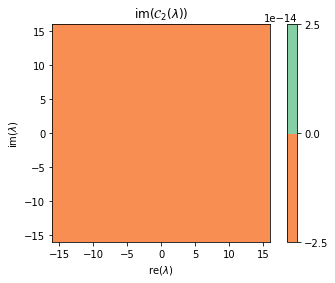

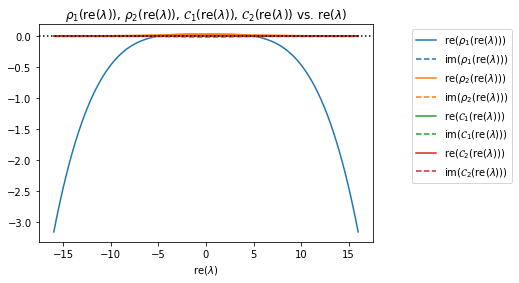

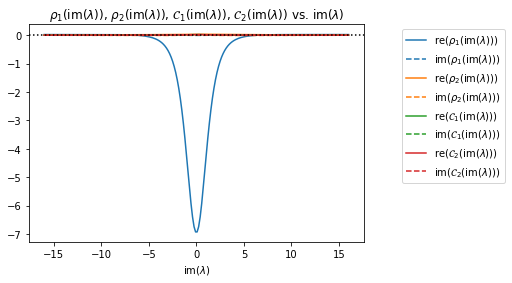

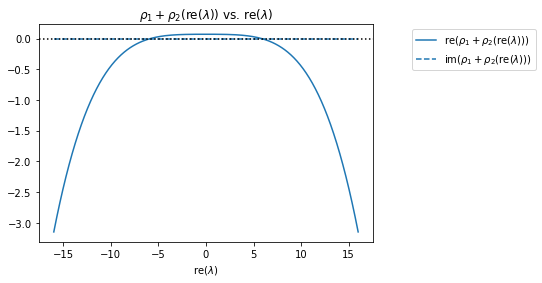

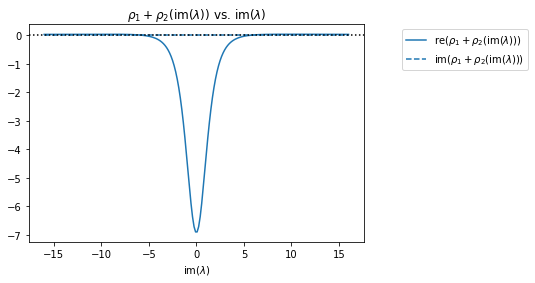

In [36]:
sbm = {'pi': np.array([0.5, 0.5]), 'psi': np.array([[ 16., 16.], [16.,  16.]]), 'undirected': True}
fs = solve_f(sbm, p_reciprocate=1)

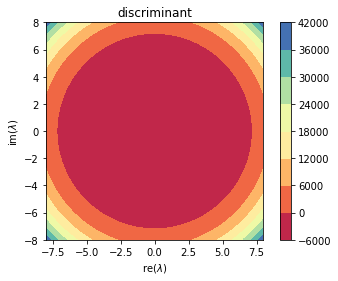

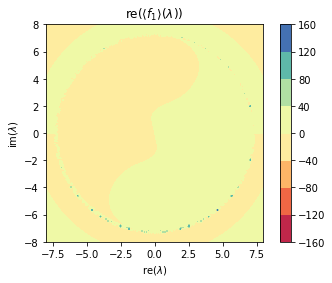

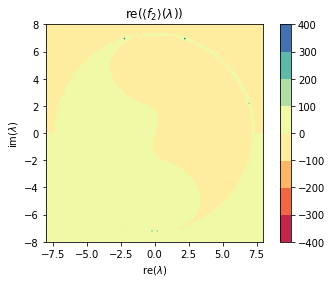

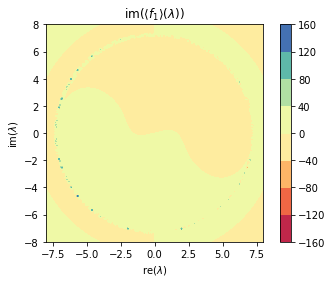

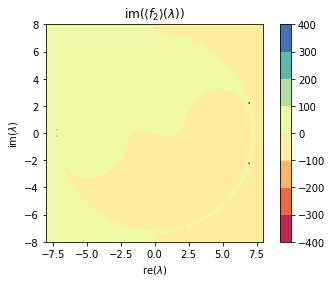

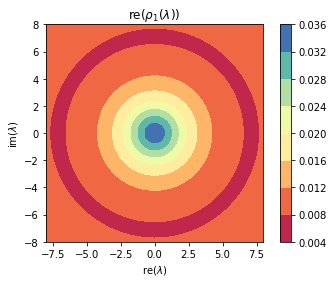

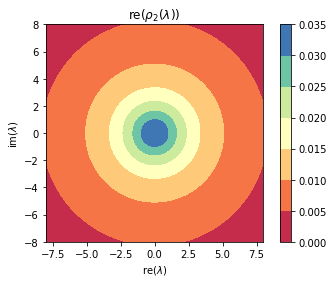

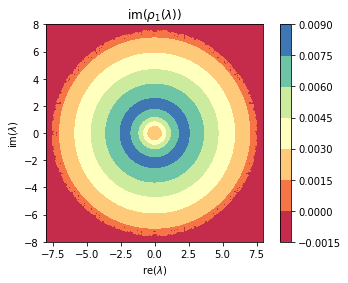

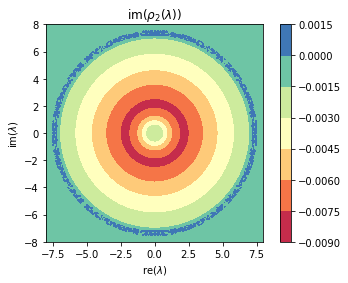

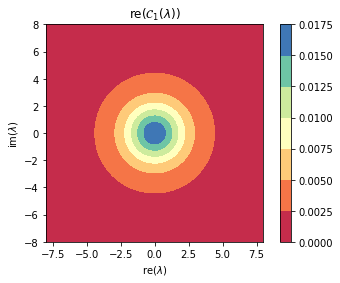

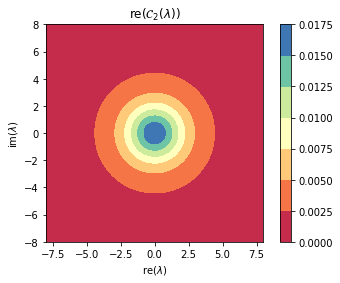

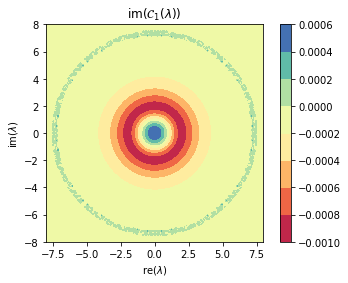

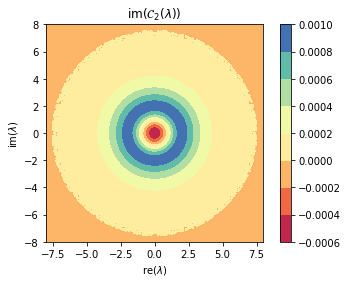

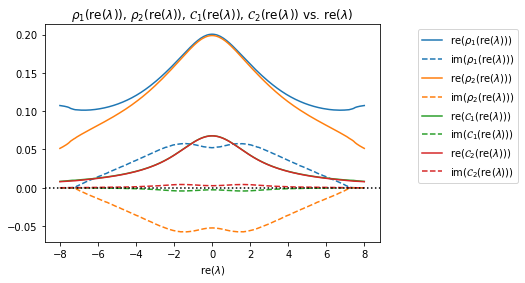

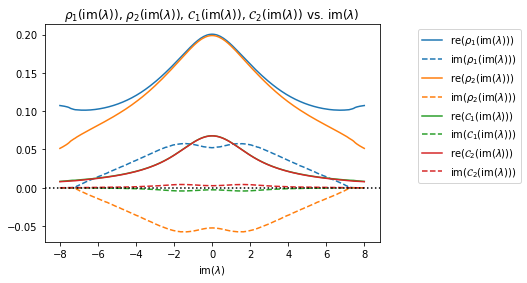

In [33]:
sbm = {'pi': np.array([0.5, 0.5]), 'psi': np.array([[ 0., 32.], [16.,  16.]]), 'undirected': True}
fs = solve_f(sbm)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


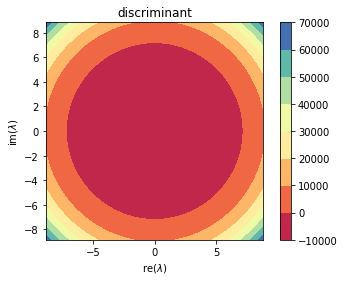

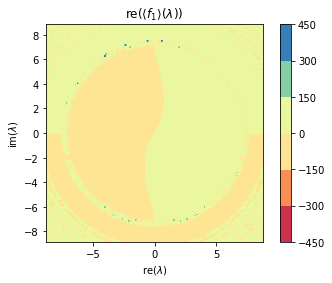

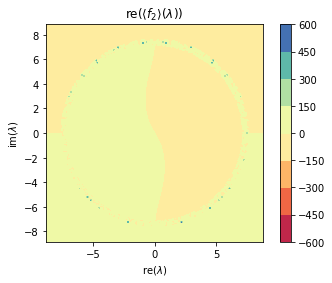

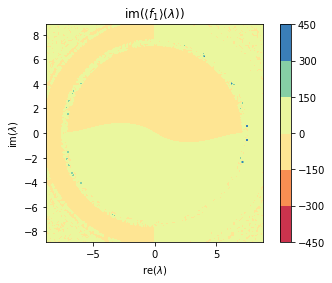

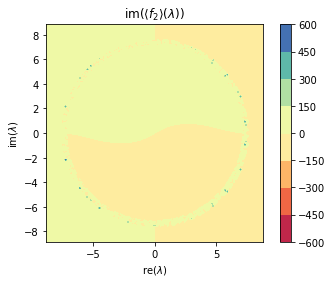

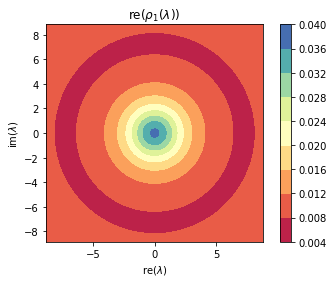

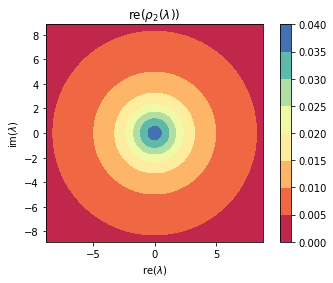

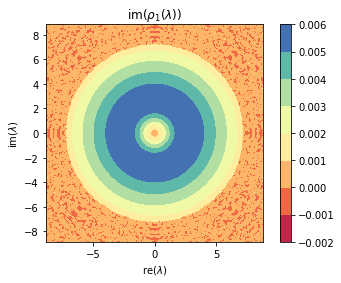

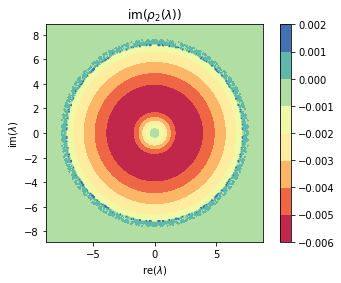

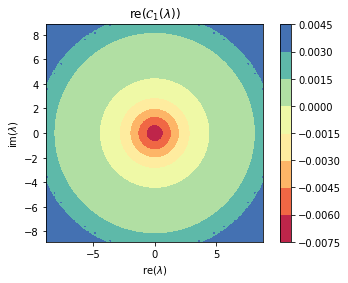

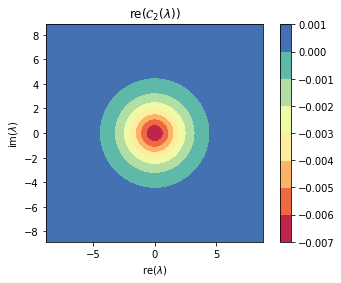

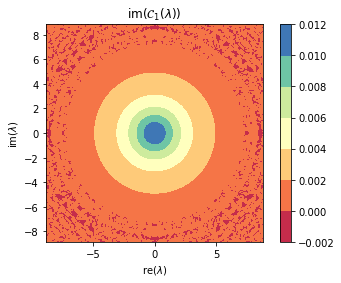

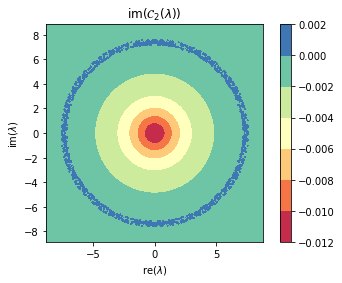

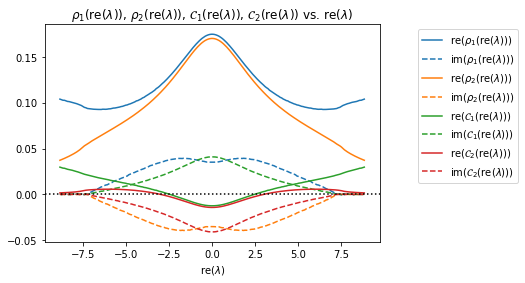

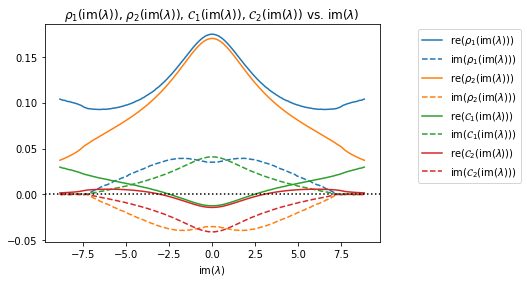

In [23]:
sbm_hom = {'pi': np.array([0.8, 0.2]), 'psi': np.array([[ 20., 12.], [12.,  20.]]), 'undirected': True}
fs = solve_f(sbm_hom)

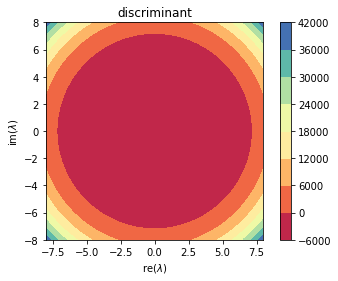

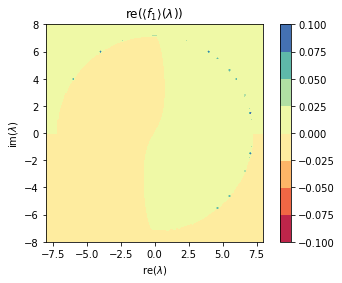

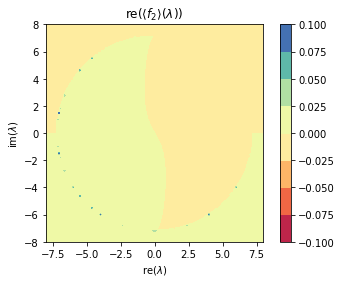

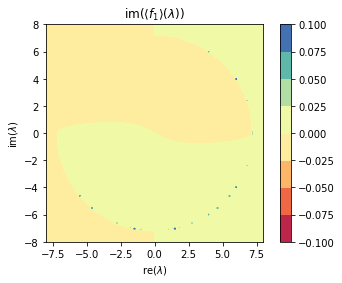

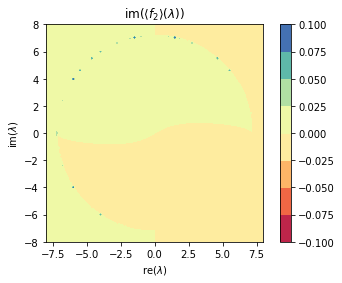

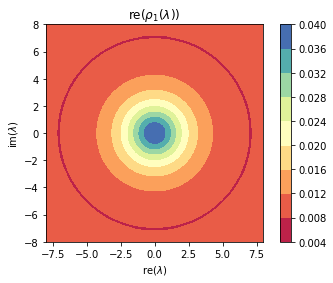

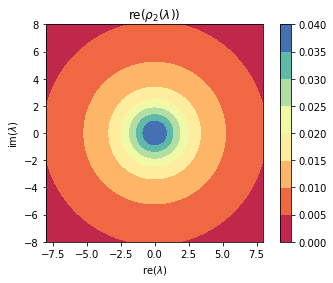

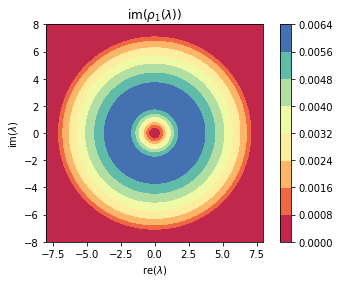

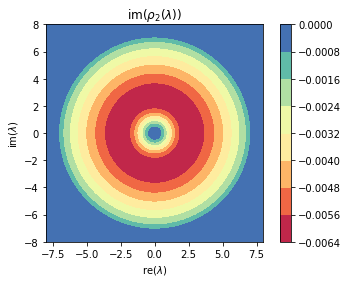

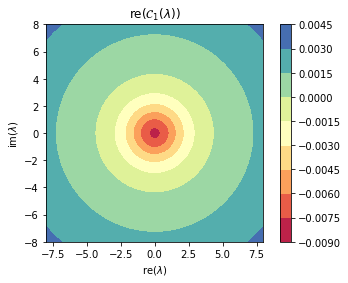

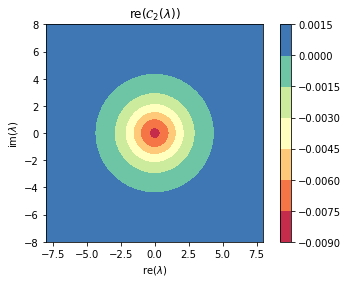

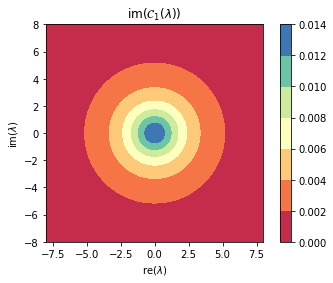

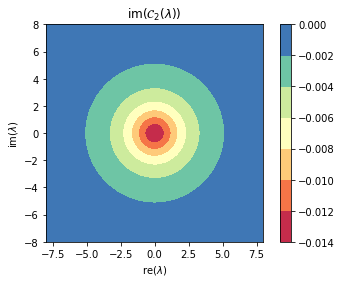

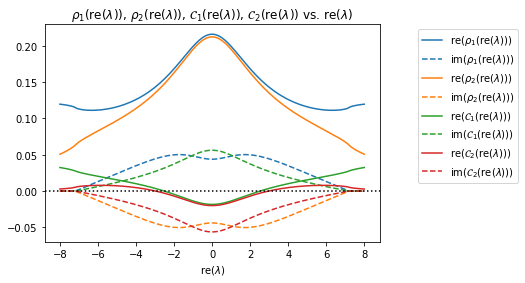

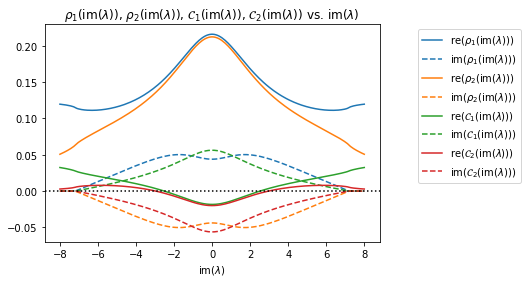

In [21]:
sbm_het = {'pi': np.array([0.5, 0.5]), 'psi': np.array([[ 12., 20.], [20.,  12.]]), 'undirected': True}
fs = solve_f(sbm_het)

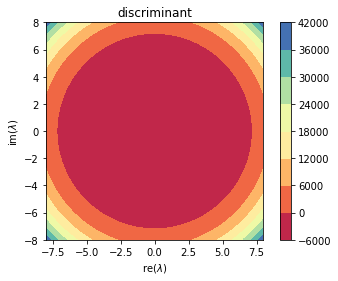

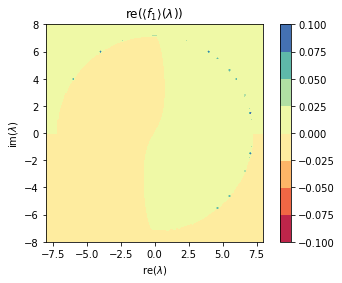

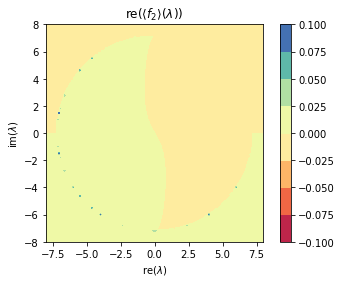

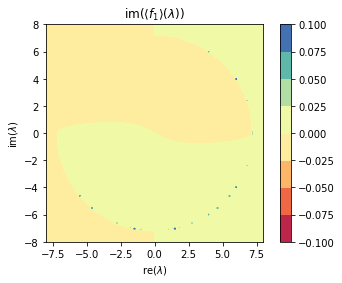

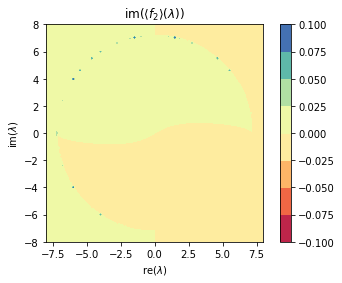

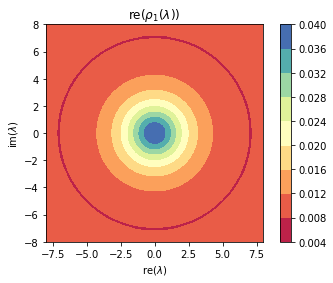

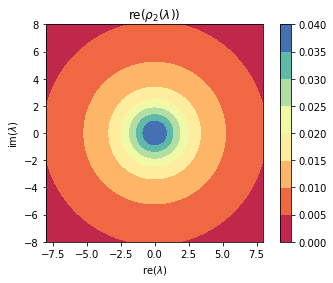

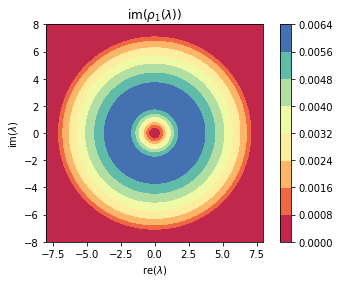

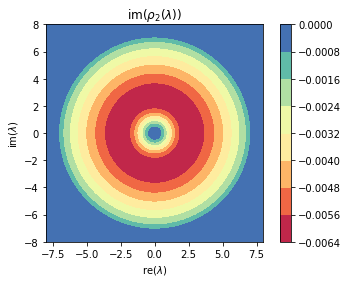

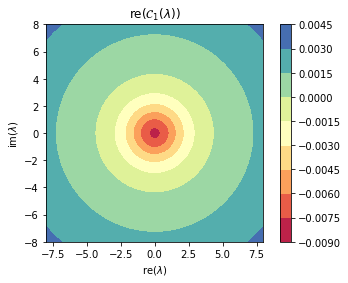

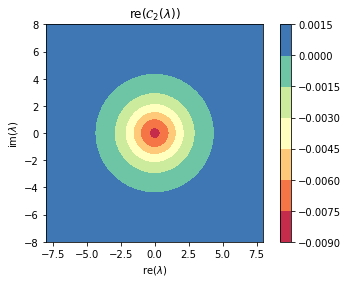

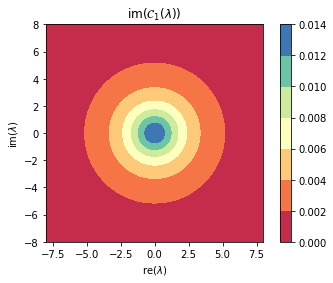

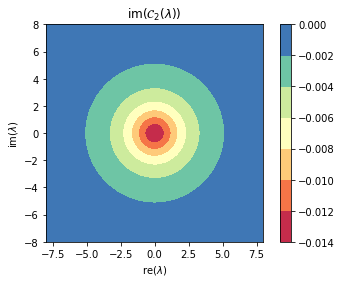

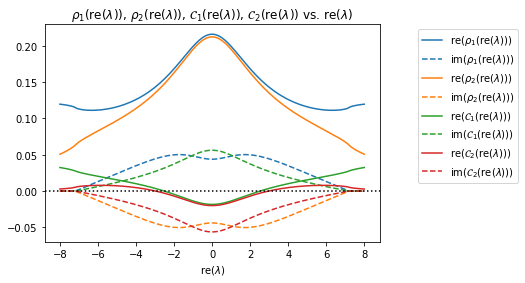

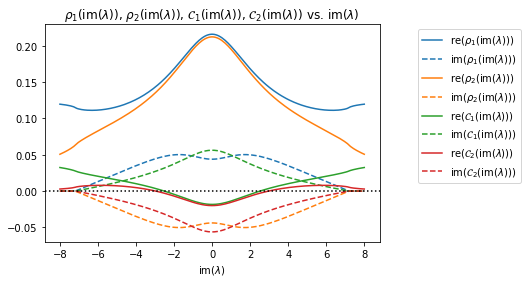

In [22]:
sbm_cop = {'pi': np.array([0.5, 0.5]), 'psi': np.array([[ 12., 20.], [12.,  20.]]), 'undirected': True}
fs = solve_f(sbm_het)

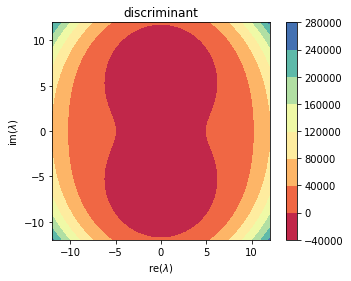

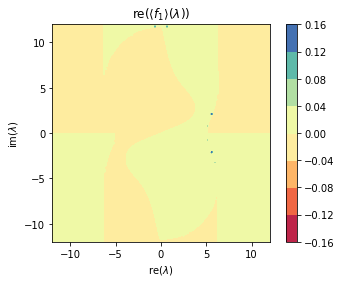

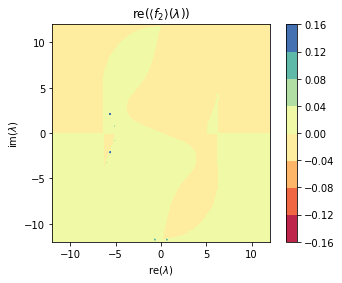

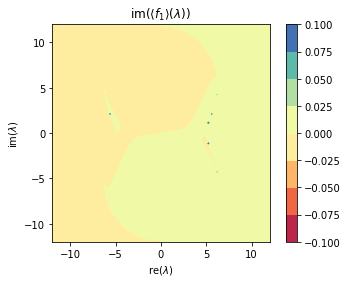

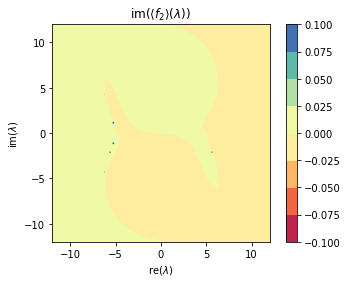

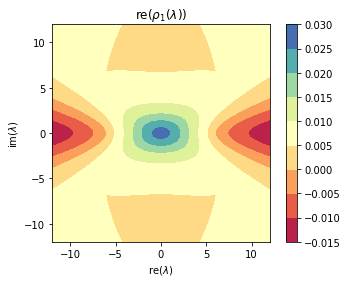

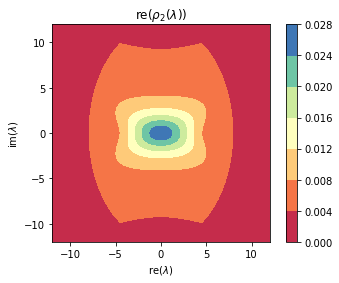

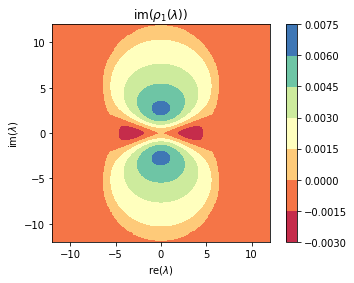

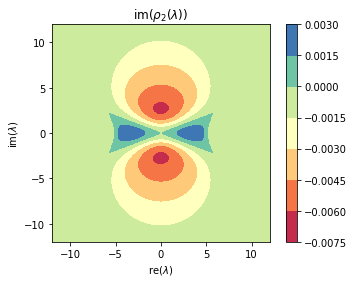

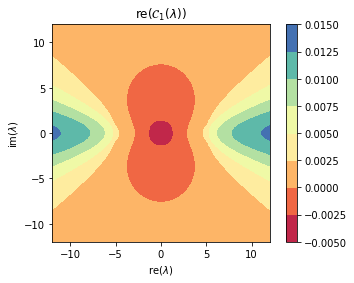

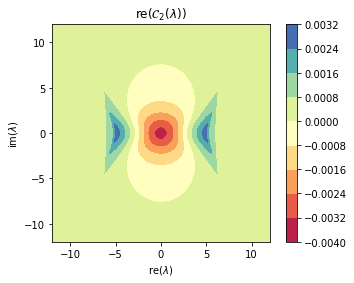

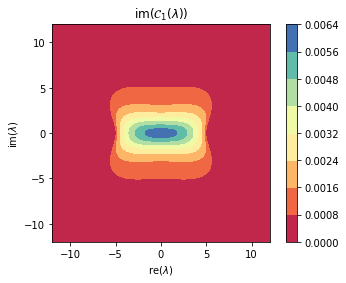

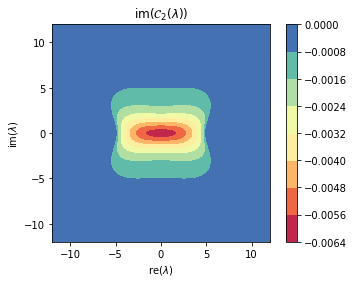

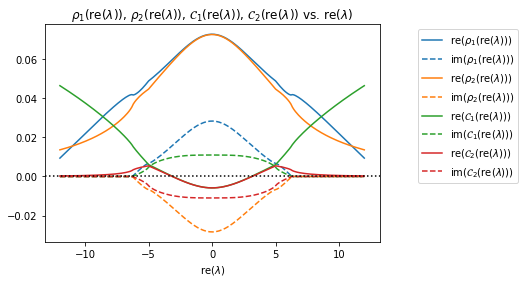

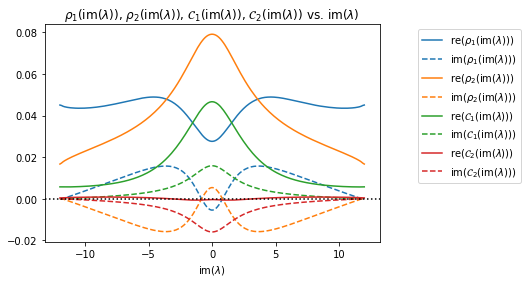

In [242]:
solve_f(sbm, p_reciprocate=0.5)

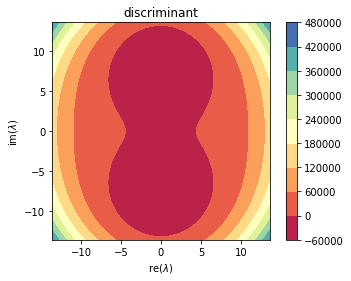

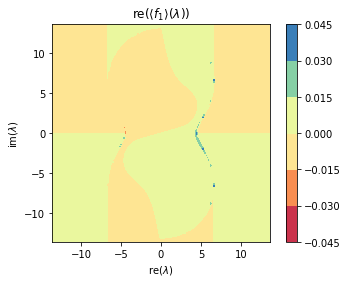

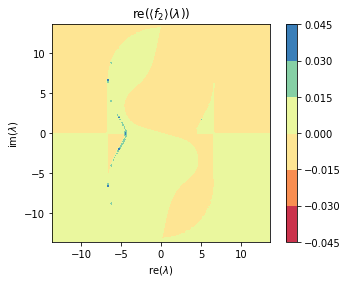

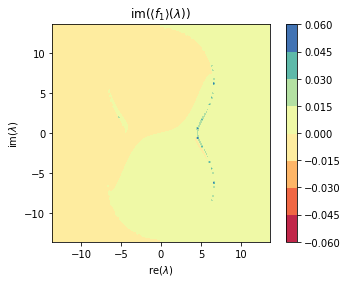

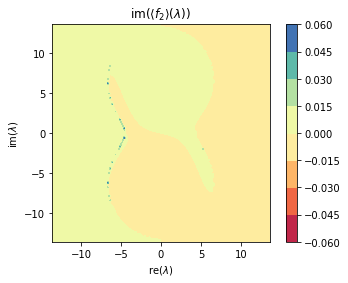

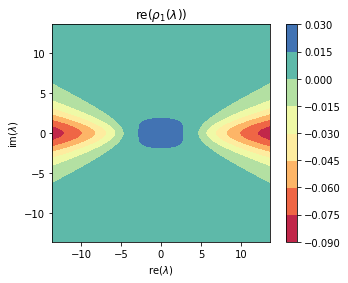

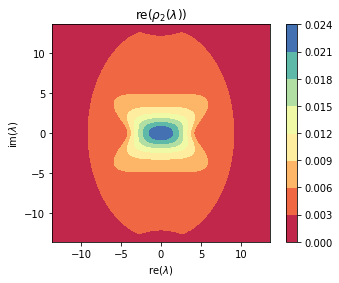

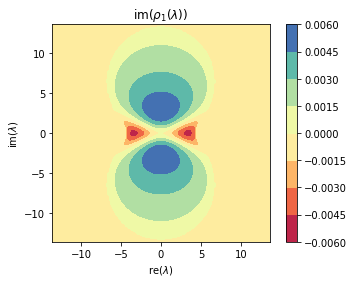

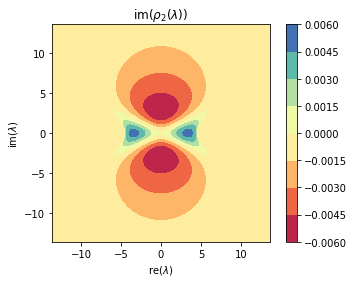

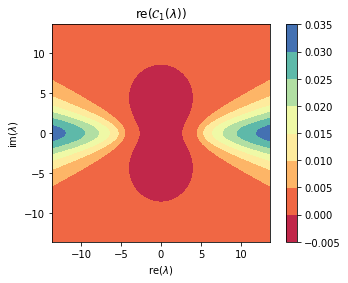

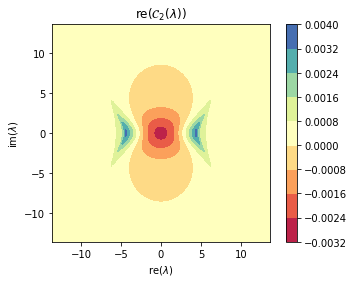

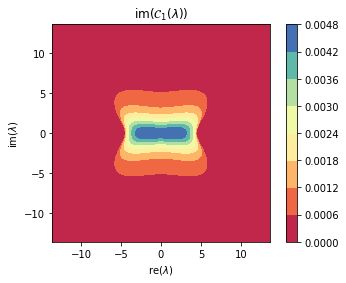

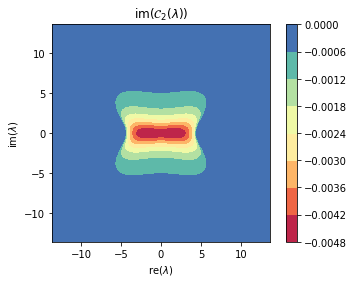

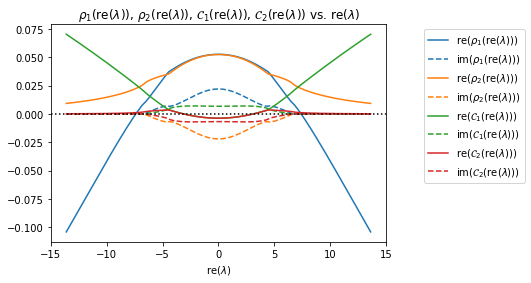

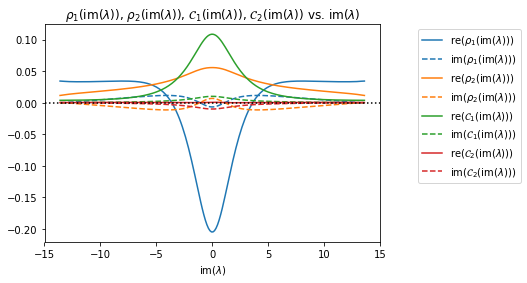

In [8]:
fs = solve_f(sbm, p_reciprocate=0.7)

In [10]:
fs[1]

[array([0.00140994, 0.00140994, 0.        , 0.        ]),
 array([0.00142593, 0.00142593, 0.        , 0.        ]),
 array([0.00144214, 0.00144214, 0.        , 0.        ]),
 array([0.00145859, 0.00145859, 0.        , 0.        ]),
 array([0.00147527, 0.00147527, 0.        , 0.        ]),
 array([0.00149219, 0.00149219, 0.        , 0.        ]),
 array([0.00150935, 0.00150935, 0.        , 0.        ]),
 array([0.00152676, 0.00152676, 0.        , 0.        ]),
 array([0.00154442, 0.00154442, 0.        , 0.        ]),
 array([0.00156233, 0.00156233, 0.        , 0.        ]),
 array([0.0015805, 0.0015805, 0.       , 0.       ]),
 array([0.00159892, 0.00159892, 0.        , 0.        ]),
 array([0.00161761, 0.00161761, 0.        , 0.        ]),
 array([0.00163657, 0.00163657, 0.        , 0.        ]),
 array([0.0016558, 0.0016558, 0.       , 0.       ]),
 array([0.00167531, 0.00167531, 0.        , 0.        ]),
 array([0.00169509, 0.00169509, 0.        , 0.        ]),
 array([0.00171515, 0.

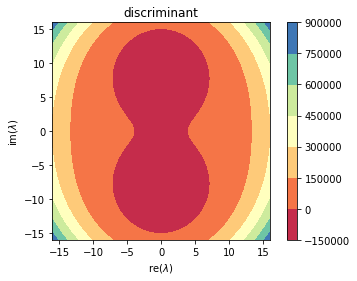

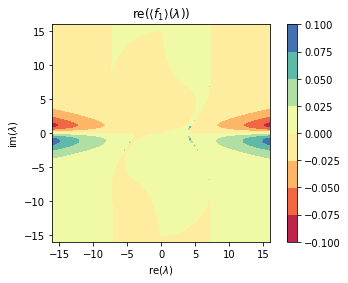

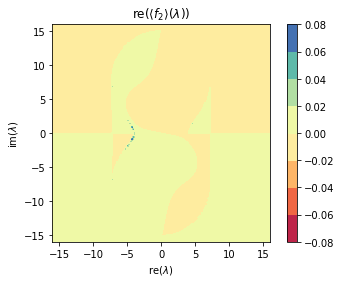

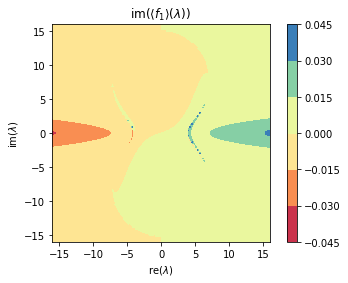

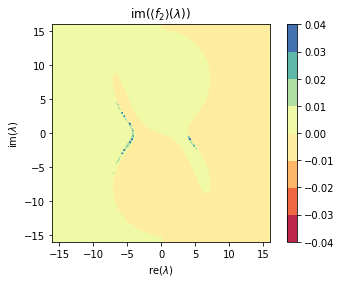

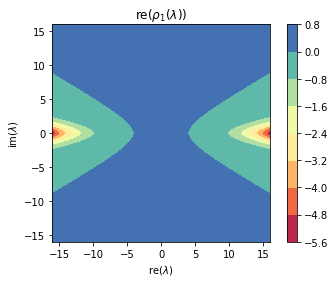

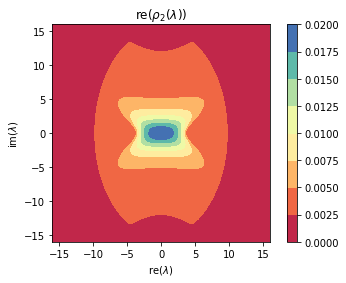

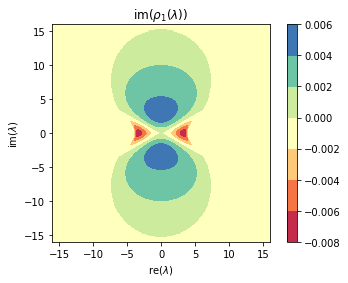

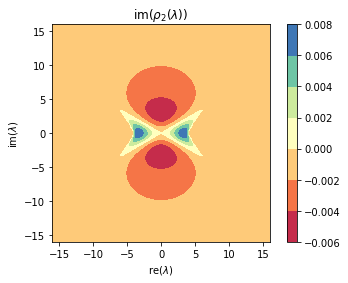

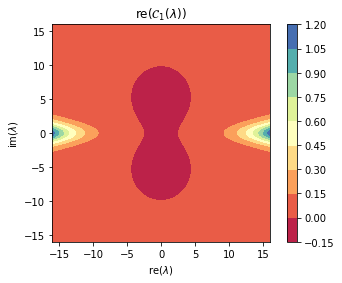

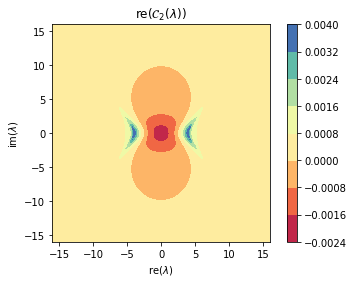

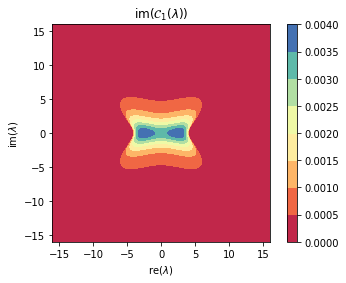

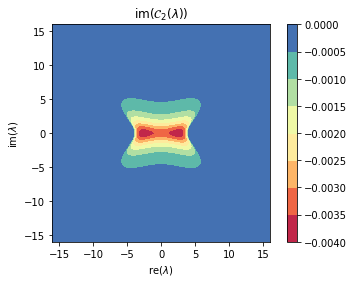

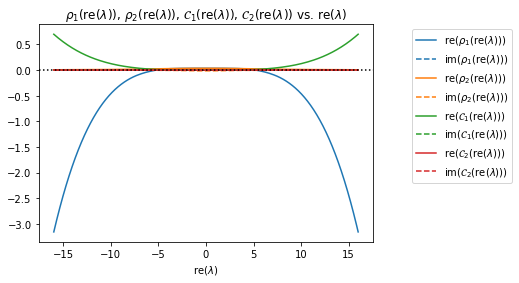

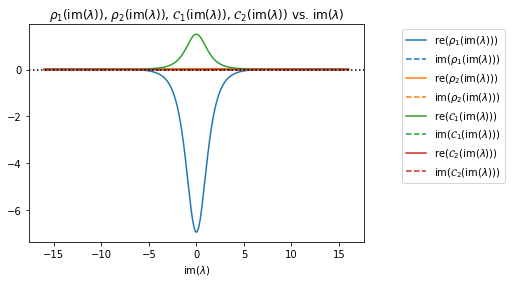

In [241]:
solve_f(sbm, p_reciprocate=1)